# EDA on hourly wind power measurement and wind prediction dataset #

In [147]:
## load modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [164]:
# function to get wind direction out of zonal and meridional wind
def WDIR(u,v):
    return (180. + 180./np.pi * math.atan2(u,v)) % 360

0.0
90.0
315.0


### General structure of data ###

In [149]:
## read data and convert TIMESTAMP from string to pandas timestamp format
data = pd.read_csv('../data/GEFCom2014Data/Wind/raw_data.csv')
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%Y%m%d %H')
data.head()

,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701


`A couple of missing values in TARGETVAR. Otherwise no missing values.`

In [150]:
## get info about type and shape of variables and about missing values in data
# only target variable has a couple of missing values 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175440 entries, 0 to 175439
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ZONEID     175440 non-null  int64         
 1   TIMESTAMP  175440 non-null  datetime64[ns]
 2   TARGETVAR  175265 non-null  float64       
 3   U10        175440 non-null  float64       
 4   V10        175440 non-null  float64       
 5   U100       175440 non-null  float64       
 6   V100       175440 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 9.4 MB


In [151]:
## look at some general statistics in data
# number of timestamps in record correspond to the maximum possible timestamps
print(data.describe())
print(f"\nfirst wind power generation measurement and wind forecast data: {data['TIMESTAMP'].min()}")
print(f"last wind power generation measurement and wind forecast data: {data['TIMESTAMP'].max()}")
print(f"Different zones: {data['ZONEID'].unique()}")
print(f"maximum number of timestamps to expect: {(data['TIMESTAMP'].max() - data['TIMESTAMP'].min())/np.timedelta64(1, 'h')+1}")

             ZONEID      TARGETVAR            U10            V10  \
count  175440.00000  175265.000000  175440.000000  175440.000000   
mean        5.50000       0.358588       0.818499       0.120835   
std         2.87229       0.310085       3.031781       3.105553   
min         1.00000       0.000000      -8.371644     -12.923576   
25%         3.00000       0.080344      -1.498648      -2.116981   
50%         5.50000       0.278670       0.548880       0.410020   
75%         8.00000       0.602033       2.805379       2.364026   
max        10.00000       1.000000      14.837177      11.401396   

                U100           V100  
count  175440.000000  175440.000000  
mean        1.272769       0.058513  
std         4.816235       5.096587  
min       -12.425352     -19.791997  
25%        -2.404248      -3.768786  
50%         1.053103       0.785671  
75%         4.734727       4.091509  
max        21.399071      16.304799  

first wind power generation measurement and 

`Remove NaN values.`

In [152]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175265 entries, 0 to 175433
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ZONEID     175265 non-null  int64         
 1   TIMESTAMP  175265 non-null  datetime64[ns]
 2   TARGETVAR  175265 non-null  float64       
 3   U10        175265 non-null  float64       
 4   V10        175265 non-null  float64       
 5   U100       175265 non-null  float64       
 6   V100       175265 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 10.7 MB


`Create columns with wind speed.`

In [154]:
data['WS100'] = np.sqrt(data['U100']**2 + data['V100']**2)
data['WS10'] = np.sqrt(data['U10']**2 + data['V10']**2)
data['WDIR100'] = data.apply(lambda x: ((180. + 180./np.pi * math.atan2(x['U100'],x['V100'])) % 360),axis=1)
data['WDIR10'] = data.apply(lambda x: ((180. + 180./np.pi * math.atan2(x['U10'],x['V10'])) % 360),axis=1)

data.head()


,ZONEID,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,WS100,WS10,WDIR100,WDIR10
0,1,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,4.652334,3.421530,321.999735,321.614439
1,1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,4.154892,3.096451,306.385781,305.473680
2,1,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,3.712577,2.795932,289.088098,287.108562
3,1,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,3.234831,2.461699,276.310236,273.345160
4,1,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,2.976332,2.279435,263.581938,260.159324


### Wind power and wind distributions for different wind parks ###

`Similar number of data for the different locations.`

In [155]:
## every wind park the same number of observations? - And remove NaNs
#for zone in range(1,11):
#    print(f"number of non-missing values in SITE {zone}: {len(data.loc[data['ZONEID']==zone])}") 
data.groupby('ZONEID').count()

,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,WS100,WS10,WDIR100,WDIR10
ZONEID,,,,,,,,,,
1,17526,17526,17526,17526,17526,17526,17526,17526,17526,17526
2,17523,17523,17523,17523,17523,17523,17523,17523,17523,17523
3,17450,17450,17450,17450,17450,17450,17450,17450,17450,17450
4,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
5,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
6,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
7,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
8,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538
9,17538,17538,17538,17538,17538,17538,17538,17538,17538,17538


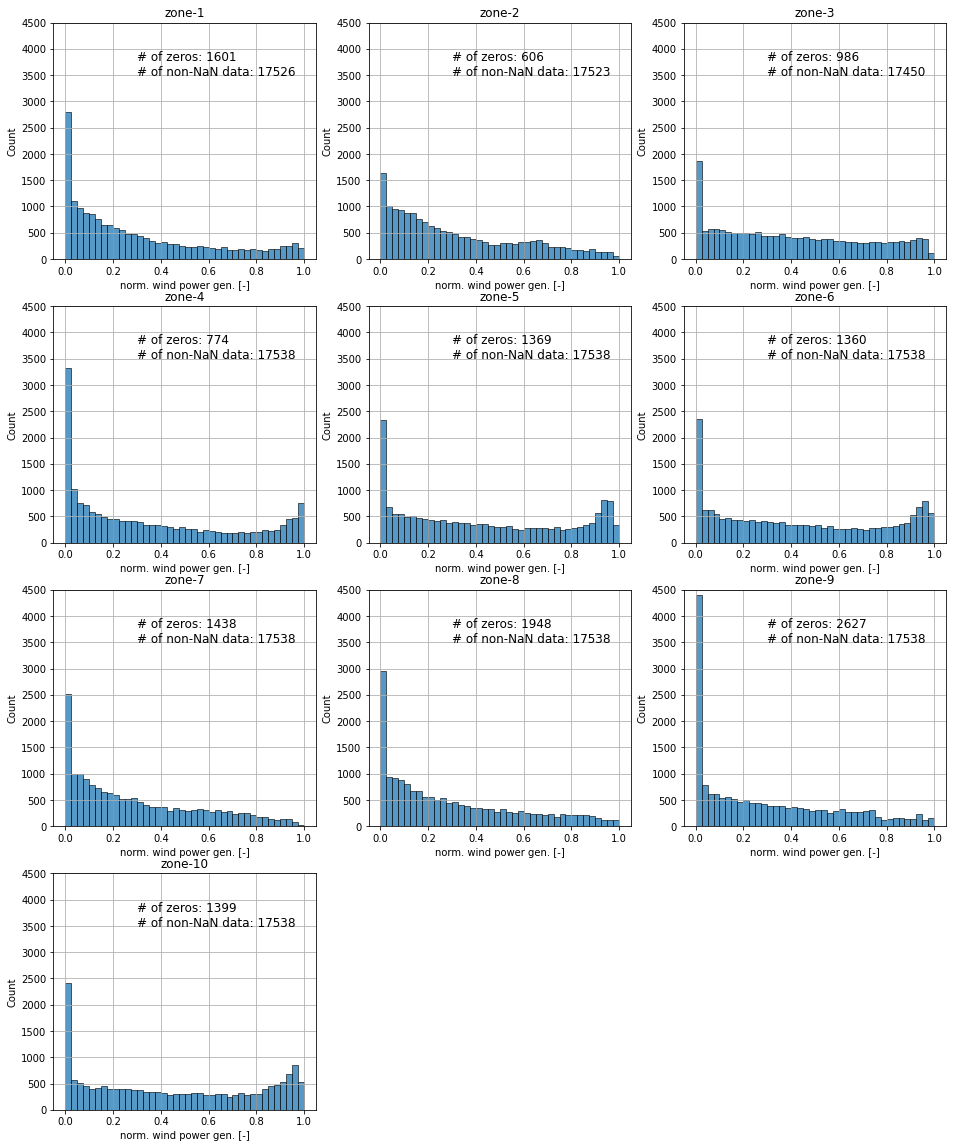

In [156]:
# distributions of wind power generation at the different sites
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(16,20))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data['TARGETVAR'].loc[data['ZONEID']==zone]
    sns.histplot(data=data_temp, ax=ax[i], bins=np.arange(0.,1.025,.025))
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel('norm. wind power gen. [-]')
    ax[i].set_ylim([0,4500])
    ax[i].grid()
    ax[i].text(.3,3500.,'# of zeros: {} \n# of non-NaN data: {}'.format((data_temp==0.).sum(),data_temp.count()),fontsize=12)
ax[-2].remove() 
ax[-1].remove()

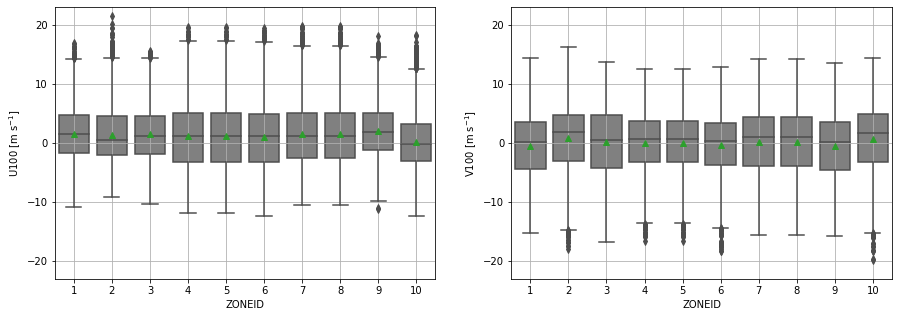

In [157]:
# distribution of zonal and meridional wind at the different sites
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax = np.reshape(ax,2)

for i,var in enumerate(['U100','V100']): 
    sns.boxplot(data=data, x='ZONEID', y=var, color='gray', showmeans=True, ax=ax[i])
    ax[i].grid()
    ax[i].set_ylim([-23.,23.])
    ax[i].set_ylabel('{} {}'.format(var,"$\mathregular{[m\ s^{-1}]}$"))

### Relationship between U100, V100 and wind power generation ###

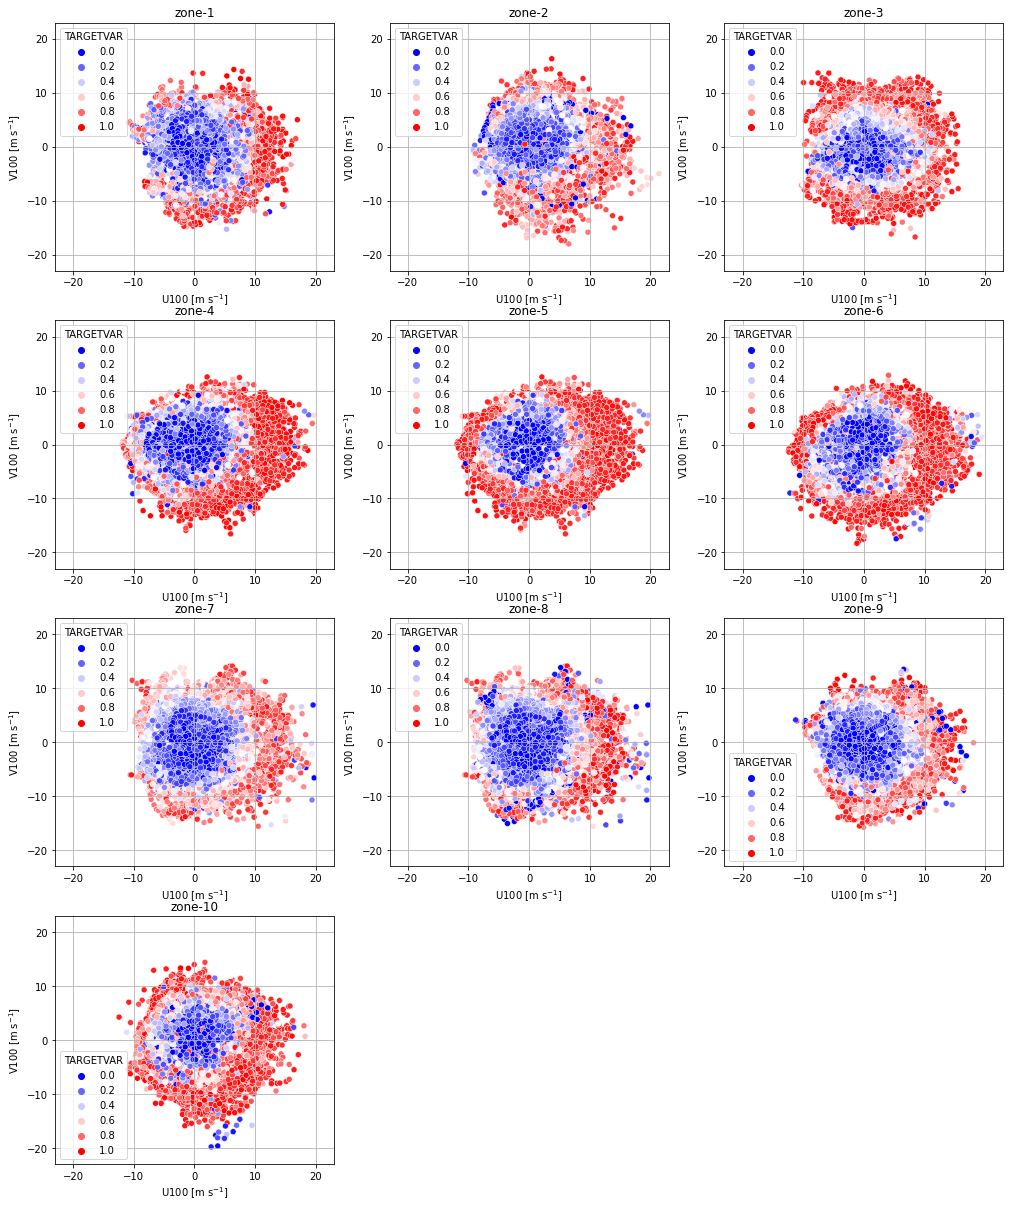

In [165]:
# scatter plots
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(17,21))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data.loc[data['ZONEID']==zone]
    sns.scatterplot(data=data_temp, x='U100', y='V100', hue='TARGETVAR', palette='bwr', ax=ax[i])
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel("U100 $\mathregular{[m\ s^{-1}]}$")
    ax[i].set_ylabel("V100 $\mathregular{[m\ s^{-1}]}$")
    ax[i].set_xlim([-23.,23.])
    ax[i].set_ylim([-23.,23.])
    ax[i].grid()
ax[-1].remove()
ax[-2].remove()

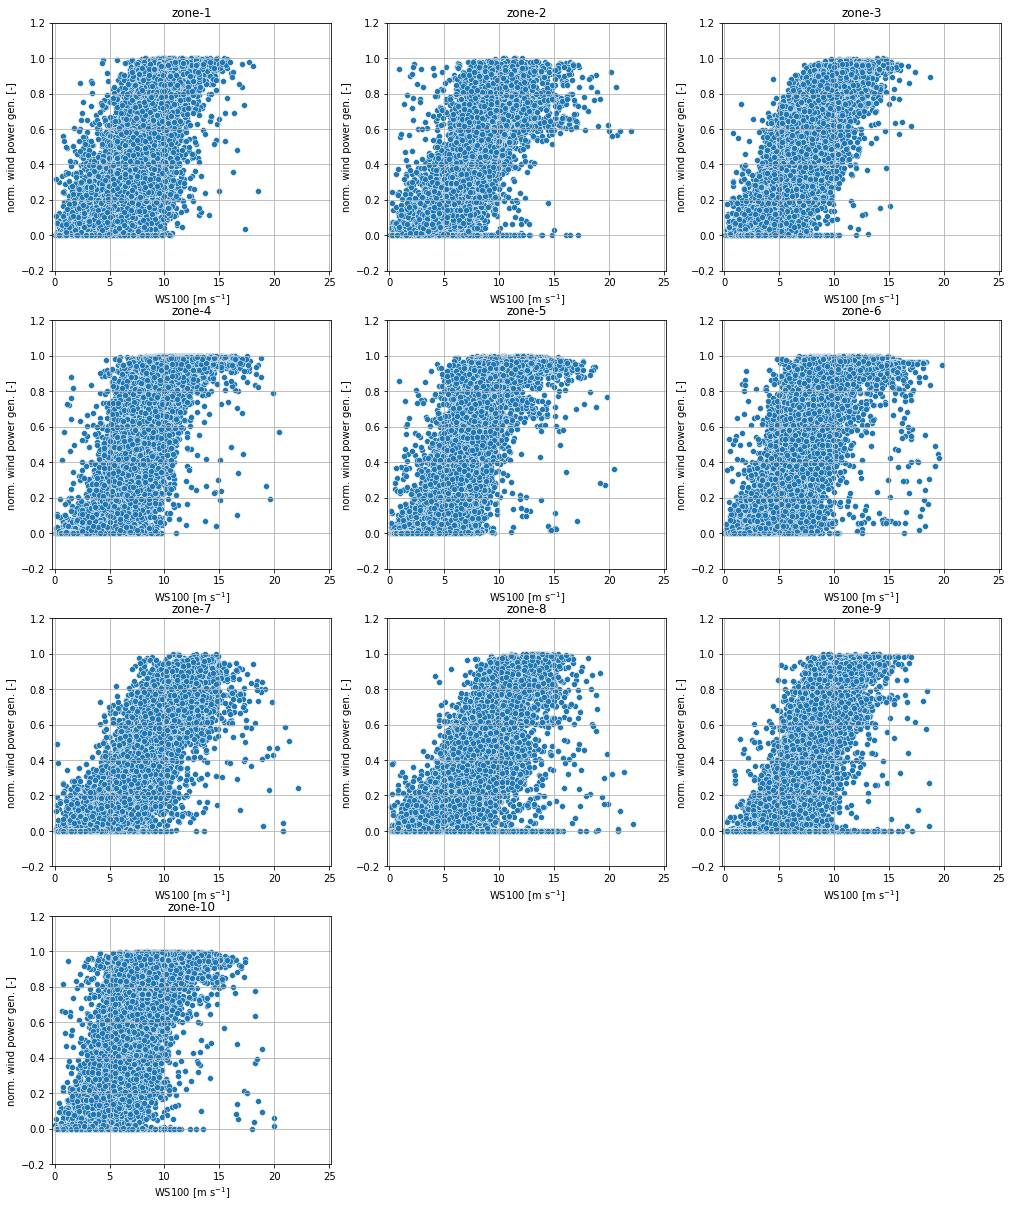

In [159]:
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(17,21))
ax = np.reshape(ax,4*3)

for i,zone in enumerate(range(1,11)):
    data_temp = data.loc[data['ZONEID']==zone]
    sns.scatterplot(data=data_temp, x='WS100', y='TARGETVAR', ax=ax[i])
    ax[i].set_title('zone-{}'.format(zone))
    ax[i].set_xlabel("WS100 $\mathregular{[m\ s^{-1}]}$")
    ax[i].set_ylabel("norm. wind power gen. [-]")
    ax[i].set_xlim([-0.2,25.2])
    ax[i].set_ylim([-0.2,1.2])
    ax[i].grid()
ax[-1].remove()
ax[-2].remove()

<AxesSubplot:>

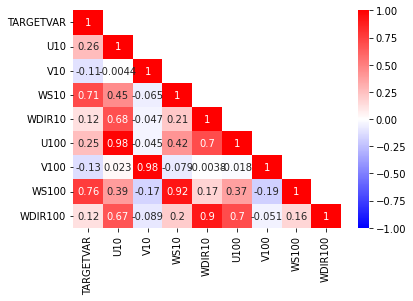

In [160]:
# correlation dataframe
data_temp=data[['TARGETVAR','U10','V10','WS10','WDIR10','U100','V100','WS100','WDIR100']].corr()

for i in range(len(data_temp)):
    for j in range(len(data_temp.columns)):
        if j>i:
            data_temp.iloc[i,j] = np.nan

sns.heatmap(data_temp, cmap='bwr', annot=True, vmin=-1., vmax=1.) 

---

### some other code snippets ###

In [161]:


# a = pd.DataFrame(data=np.array([[1.,2.,3.],[-1.,5.,6.]]),columns=['A','B','E'])
# b = pd.DataFrame(data=np.array([[1.,2.,6.],[-1.,5.,4.]]),columns=['C','D','E'])
# c = pd.merge(a,b,on='E',how='left')

# print(a)
# print(b)
# print(c)
